<h2>Fun with Word Embeddings</h2>
<em>Christopher Δ 05/2025</em>
<br>
<ol>
<li>load a word2vec embedding model
<li>apply the model to a relatively short list of common English words
<li>begin at a specified word and engage in a 'random walk' limited to unvisited, similar words
<li>store these in an ordered list
<li>calculate the first four principal components of the visited words, reducing the embedding dimensionality from 300 to 4
<li>generate an animated plot, where x, y, size, and color represent the respective principal components
</ol><br>


In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
import gensim.downloader as api
from gensim.models import KeyedVectors

MODEL_NAME = "glove-wiki-gigaword-300"   # "Pre-trained glove vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased."
                                         # https://huggingface.co/fse/glove-wiki-gigaword-300 
                                         # https://nlp.stanford.edu/projects/glove/
WORD_LIST_PATH = "/usr/share/dict/words" # https://packages.debian.org/sid/wamerican
SUBSET_FILEN = "model_subset.wv" 

try:
    model = KeyedVectors.load_word2vec_format(SUBSET_FILEN)
    word_list = [w.strip().lower() for w in open(WORD_LIST_PATH, "r")]
    words_in_common = [w for w in word_list if w in model]
except:   
    model = api.load(MODEL_NAME) 
    word_list = [w.strip().lower() for w in open(WORD_LIST_PATH, "r")]
    words_in_common = [w for w in word_list if w in model]  # eliminate words that are not modeled
    model = model.vectors_for_all(words_in_common) # subset model
    model.save_word2vec_format(SUBSET_FILEN)
    

In [2]:
def random_talk(token, N=5, limit=128, model=model, words_in_common=words_in_common):
    """
    Takes a word, finds the N most similar words (according to cosine), 
    chooses one at random.
    If we've been there before, checks others until we find one. Yields word.
    """
    never_here = set(words_in_common)
    been_here = set()
    for i in range(limit):
        if i % 1000 == 0 and i > 1:
            model = model.vectors_for_all(never_here)
        yield(token)
        been_here.add(token)
        never_here.remove(token)
        these = model.most_similar(token, topn=N)
        rando = np.random.randint(N)
        last_token = token
        token = these[rando][0]
        j = 1
        n = N
        while token in been_here: # ensure we haven't visited
            token = these[(rando + j) % N][0]
            j += 1
            if i > N:
                n += 1
                these = model.most_similar(last_token, topn=n)
                token = these[n-1][0]

def convert_to_pca_model(w2v_model, n_components=2):
    vectors = np.array([w2v_model[word] for word in w2v_model.index_to_key])
    pca = PCA(n_components=n_components)
    pca.fit(vectors)
    return pca
    

In [3]:
words = [w for w in random_talk("pianoforte", 3, 512)]
    

In [4]:
pca = convert_to_pca_model(model, n_components=4)
pca_dict = {key: pca.transform(model[key].reshape(1,-1)).reshape(-1) for key in model.index_to_key} # 😎
component_list = [[key] + list(pca_dict[key]) for key in words]
df = pd.DataFrame(component_list, columns = ["token", "pc1", "pc2", "pc3", "pc4"])
positron = -1.01 * min(df.pc3) # fung mung smung
df.pc3 = pd.Series([int(x) for x in (df.pc3 + positron)**1.7 * 100]) # needs to be a positive integer
    

In [5]:
print(df)
    

           token       pc1       pc2  pc3       pc4
0     pianoforte -0.857173  0.178221  213  0.716352
1    violoncello -1.030620  0.612250  227  0.417118
2           oboe -0.106330  1.086826  158  1.175136
3        bassoon -0.470143  0.647932  125  0.835233
4          oboes -0.409327  0.563090   84  0.260735
..           ...       ...       ...  ...       ...
507   stabilizes -0.371566 -0.644463  242 -0.132313
508      worsens  0.095323 -0.904886  500 -0.488500
509    escalates  0.075889 -0.734117  513 -0.311544
510    escalated  1.512377 -0.683954  588 -1.460347
511   escalating  1.818683 -1.748233  634 -1.164389

[512 rows x 5 columns]


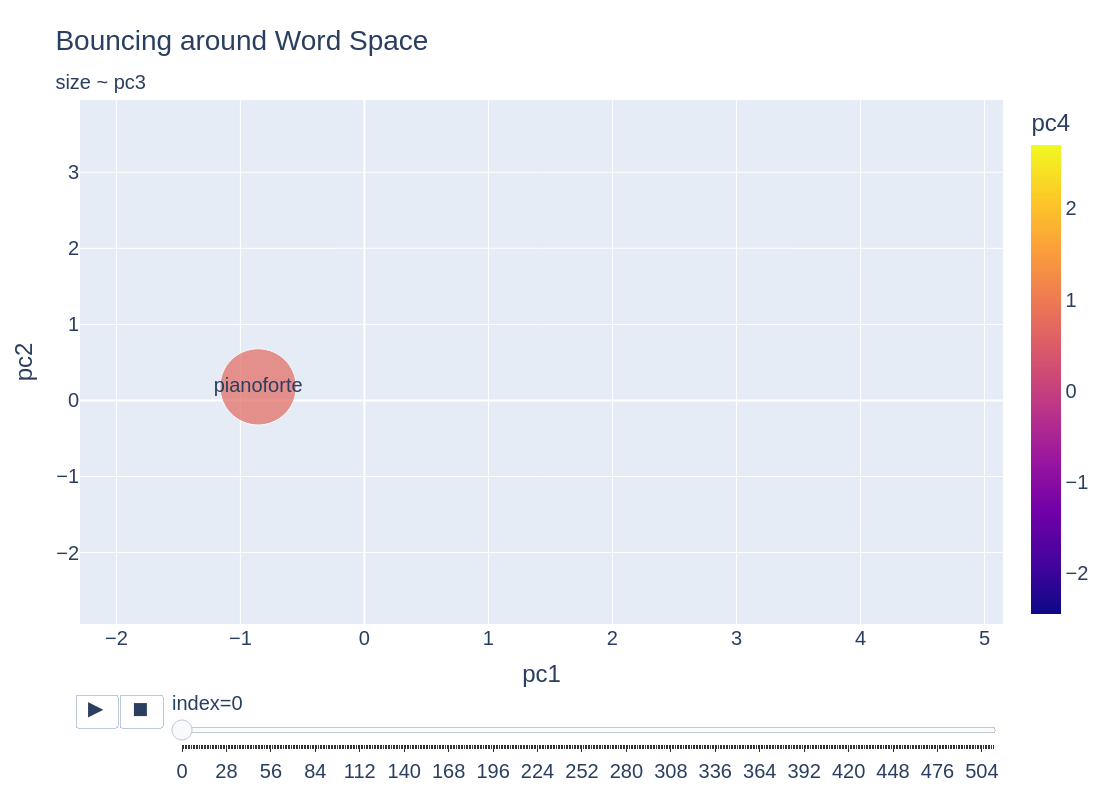

In [6]:
ext = 0.25
range_x = [min(df.pc1) - ext, max(df.pc1) + ext]
range_y = [min(df.pc2) - ext, max(df.pc2) + ext]
range_c = [min(df.pc4)      , max(df.pc4)      ]

fig = px.scatter(df, x = "pc1", y = "pc2", size = "pc3", color = "pc4",
                 text="token", size_max=120, height=800, width=800,
                 range_x = range_x, range_y = range_y, range_color = range_c, 
                 title="Bouncing around Word Space", subtitle = "size ~ pc3\n",
                 animation_frame = df.index)

fig.update_layout(font=dict(size=20))
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 450
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 420

fig.show()
fig.write_html("word_space_animation.html") # to be spliced into exported notebook
    

In [7]:
[print(x) for x in list(api.info()['models'].keys())]

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


[None, None, None, None, None, None, None, None, None, None, None, None, None]